This example shows how to set up a fermionic PEPS with Z2 symmetry and the 'flat' backend using `symmray` and `quimb`, then optimize using imaginary time simple update, then evaluate the energy using boundary contraction. Because we are using Z2 symmetry we rely on setting a chemical potential to reach half-filling.

In [1]:
%config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn

import symmray as sr

In [2]:
symmetry = "Z2"

Lx = 4
Ly = 4
D = 6
seed = 1

# note fully random initialization will not be a very
# good initial state, used as a demonstration only here
peps = sr.PEPS_fermionic_rand(
    symmetry=symmetry,
    Lx=Lx,
    Ly=Ly,
    bond_dim=D,
    seed=seed,
    phys_dim=4,
    flat=True,
    subsizes="equal",
)

In [3]:
# verify the spin structure using a basic cluster expectation
Ospin = sr.fermi_spin_operator_local_array(symmetry, flat=True)

peps.compute_local_expectation_cluster(
    {(site,): Ospin for site in peps.gen_site_coos()},
    max_distance=1,
    return_all=True,
)

{((0, 0),): np.float64(-0.0327419300969182),
 ((0, 1),): np.float64(0.01598635686807416),
 ((0, 2),): np.float64(0.056781828870607676),
 ((0, 3),): np.float64(0.04050117272143959),
 ((1, 0),): np.float64(-0.032587690022989765),
 ((1, 1),): np.float64(-0.00016372219003649158),
 ((1, 2),): np.float64(0.006227043206973079),
 ((1, 3),): np.float64(0.033253735745883584),
 ((2, 0),): np.float64(-0.056101826385629536),
 ((2, 1),): np.float64(-0.012242773893809566),
 ((2, 2),): np.float64(-0.0028582463963720273),
 ((2, 3),): np.float64(-0.0128546755014783),
 ((3, 0),): np.float64(-0.08064024594552714),
 ((3, 1),): np.float64(0.022580207467178273),
 ((3, 2),): np.float64(-0.0018963528877691538),
 ((3, 3),): np.float64(0.05837888912565602)}

In [4]:
terms = sr.ham_fermi_hubbard_from_edges(
    symmetry=symmetry,
    edges=tuple(peps.gen_bond_coos()),
    t=1.0,
    U=8.0,
    mu=4.0,
    flat=True,
)
ham = qtn.LocalHamGen(terms)

In [ ]:
su = qtn.SimpleUpdateGen(
    peps,
    ham,
    # flat only supports zero cutoff
    cutoff=0.0,
    second_order_reflect=True,
    # SimpleUpdateGen computes cluster energies by default
    # which might not be accurate
    compute_energy_every=10,
    compute_energy_opts=dict(max_distance=1),
    compute_energy_per_site=True,
    # use a fixed trotterization order
    ordering="sort",
    # if the gauge difference drops below this, we consider the PEPS converged
    tol=1e-9,
)

In [6]:
# run the evolution, these are reasonable defaults
tau = 0.5 * D ** (-3 / 2)
steps = round(50 / tau)

In [7]:
su.evolve(steps, tau=tau)

n=1470, D=6, tau=0.034, max|dS|=2.43e-07, energy≈-4.4002: 100%|##########| 1470/1470 [08:41<00:00,  2.82it/s] 


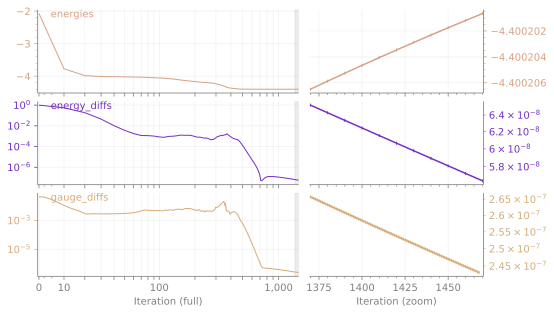

In [8]:
su.plot();

In [9]:
gs = su.get_state()

Check energy properly with boundary contraction and increasing $\chi$.

In [10]:
terms_without_mu = sr.ham_fermi_hubbard_from_edges(
    symmetry=symmetry,
    edges=tuple(gs.gen_bond_coos()),
    t=1.0,
    U=8.0,
    mu=0.0,
)

terms_without_mu = {k: v.to_flat() for k, v in terms_without_mu.items()}

In [11]:
full_energies = {}

for chi in [16, 24, 32, 48, 64]:
    en = (
        gs.compute_local_expectation(
            terms_without_mu,
            normalized=True,
            max_bond=chi,
            cutoff=0.0,
        )
        / gs.nsites
    )
    print(f"chi={chi}: E/N = {en}")
    full_energies[chi] = en

chi=16: E/N = -0.41298464813267194
chi=24: E/N = -0.4128461586903418
chi=32: E/N = -0.41284534674196816
chi=48: E/N = -0.4128488889859121
chi=64: E/N = -0.4128496765292675


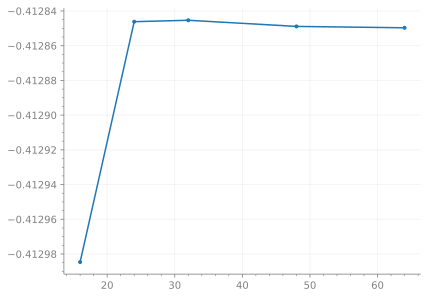

In [12]:
qu.plot(full_energies.keys(), full_energies.values(), marker=".");

In [15]:
# verify the spin structure using a basic cluster expectation
Ospin = sr.fermi_spin_operator_local_array(symmetry).to_flat()
# Nelec = sr.fermi_number_operator_spinful_local_array(symmetry).to_flat()

gs.compute_local_expectation_cluster(
    {(site,): Ospin for site in peps.gen_site_coos()},
    max_distance=2,
    return_all=True,
)

{((0, 0),): np.float64(0.2953258067753308),
 ((0, 1),): np.float64(-0.29419824794181365),
 ((0, 2),): np.float64(0.29425937480542014),
 ((0, 3),): np.float64(-0.2954975247267074),
 ((1, 0),): np.float64(-0.29394455516736284),
 ((1, 1),): np.float64(0.31362285579351756),
 ((1, 2),): np.float64(-0.3134577246439194),
 ((1, 3),): np.float64(0.2939256428433463),
 ((2, 0),): np.float64(0.2941214990566645),
 ((2, 1),): np.float64(-0.31373893091142335),
 ((2, 2),): np.float64(0.3136852540451318),
 ((2, 3),): np.float64(-0.2941659031339183),
 ((3, 0),): np.float64(-0.2955566310414538),
 ((3, 1),): np.float64(0.29411515712065345),
 ((3, 2),): np.float64(-0.29414320076993),
 ((3, 3),): np.float64(0.295582934224184)}